## 1. Load Data

In [1]:
#load in necessary packages
import pandas as pd
import numpy as np
pd.options.display.max_columns = 100
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import seaborn as sns


In [2]:
df = pd.read_csv('olineman_full2.csv')

In [3]:
df.head()

,displayName,pff_positionLinedUp,x_std,y_std,dir_std,o_std,yardLine_std,Opp_Dist,closestOpp_Id,Team_Dist,closestTeam_Id,QB_Dist,closestQB_Id,FootDist,secondsIntoGame,secondsIntoPlay,gameId,playId,nflId,team,down,yardsToGo,defensiveTeam,homeOrAway,preSnapHomeScore,preSnapVisitorScore,pff_nflIdBlockedPlayer,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,penaltyCommitted,olineman_win,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed
0,Donovan Smith,LT,41.55,26.89,5.545260,1.012640,33,2.151279,53504.0,1.293406,42404.0,4.627883,25511.0,3.162183,87,NaN,2021090900,97,42377.0,TB,3,2,DAL,home,0,0,42403.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,0,0,0.0,0.0,1.0,0.0
1,Donovan Smith,LT,41.54,26.88,5.431814,1.012640,33,2.161227,53504.0,1.287051,42404.0,4.605779,25511.0,3.049098,87,NaN,2021090900,97,42377.0,TB,3,2,DAL,home,0,0,42403.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,0,0,0.0,0.0,1.0,0.0
2,Donovan Smith,LT,41.53,26.89,3.869395,0.991871,33,2.172211,53504.0,1.296534,42404.0,4.591841,25511.0,3.067507,87,NaN,2021090900,97,42377.0,TB,3,2,DAL,home,0,0,42403.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,0,0,0.0,0.0,1.0,0.0
3,Donovan Smith,LT,41.50,26.89,3.013485,0.991871,33,2.211990,53504.0,1.306331,42404.0,4.602445,25511.0,3.059412,87,NaN,2021090900,97,42377.0,TB,3,2,DAL,home,0,0,42403.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,0,0,0.0,0.0,1.0,0.0
4,Donovan Smith,LT,41.46,26.91,2.924474,0.963247,33,2.253908,53504.0,1.348332,42404.0,4.608188,25511.0,3.021523,87,NaN,2021090900,97,42377.0,TB,3,2,DAL,home,0,0,42403.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,0,0,0.0,0.0,1.0,0.0


In [4]:
df = df[df.penaltyCommitted != 1]

In [5]:
pd.options.display.min_rows = 115
df.isnull().sum()
print(df.isna().sum())

displayName                    0
pff_positionLinedUp            0
x_std                          0
y_std                          0
dir_std                        0
o_std                          0
yardLine_std                   0
Opp_Dist                       0
closestOpp_Id                  0
Team_Dist                      0
closestTeam_Id                 0
QB_Dist                        0
closestQB_Id                   0
FootDist                       0
secondsIntoGame                0
secondsIntoPlay                5
gameId                         0
playId                         0
nflId                          0
team                           0
down                           0
yardsToGo                      0
defensiveTeam                  0
homeOrAway                     0
preSnapHomeScore               0
preSnapVisitorScore            0
pff_nflIdBlockedPlayer     44284
offenseFormation            1446
personnelO                   180
defendersInBox              1446
personnelD

In [6]:
#convert nulls to 0 where relevant
df.secondsIntoPlay[df.secondsIntoPlay.isna()] = 0.0
df.defendersInBox = df.defendersInBox[df.defendersInBox.isna()] = 0
df.pff_nflIdBlockedPlayer = df.pff_nflIdBlockedPlayer[df.pff_nflIdBlockedPlayer.isna()] = 0

In [7]:
#remove remaining null columns
df = df.dropna()

## 2. Binary Classifier

In [8]:
# one hot encode categorical variables
X = df.drop(['olineman_win' ,'pff_beatenByDefender',
                  'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed'], axis = 1)
X = X.drop(['team', 'defensiveTeam'], axis = 1)
dummies = pd.get_dummies(X[['pff_positionLinedUp', 'homeOrAway', 'offenseFormation', 'personnelO', 'personnelD', 'dropBackType', 'pff_passCoverage', 'pff_passCoverageType']])
X = X.drop(['pff_positionLinedUp', 'homeOrAway', 'offenseFormation', 'personnelO', 'personnelD', 'dropBackType', 'pff_passCoverage', 'pff_passCoverageType'], axis = 1)
X = X.join(dummies)
y = df[['olineman_win', 'pff_beatenByDefender',
                   'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed']]

In [9]:
#drop variables to prevent perfect collinearity
X = X.drop(['displayName', 'x_std', 'y_std', 'nflId', 'playId', 'gameId', 'pff_positionLinedUp_C', 'offenseFormation_JUMBO','personnelO_6 OL, 2 RB, 2 TE, 0 WR', 'personnelD_6 DL, 1 LB, 4 DB', 'homeOrAway_away', 'dropBackType_UNKNOWN', 'pff_passCoverage_Miscellaneous', 'pff_passCoverageType_Other'], axis = 1)

In [10]:
#create df for binary classification and multiclassification
df2 = X.join(y.olineman_win)
y2 = y.drop('olineman_win', axis = 1)
#df4 = X.join(y2)
#df4.to_csv('multiclass.csv', index = False)

### 2.1 Under Sampling

1    1505099
0     178667
Name: olineman_win, dtype: int64


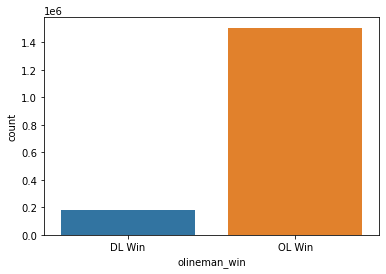

In [11]:
#plot
print(y.olineman_win.value_counts())
class_names = ['DL Win','OL Win']
ax = sns.countplot(x=y.olineman_win); 
ax.set_xticklabels(class_names)
plt.show()

In [12]:
# Divide by class
df_class_0    = df2[df2['olineman_win'] == 0] #class with more samples
df_class_1    = df2[df2['olineman_win'] == 1] #class with fewer samples
count_class_0 = len(df_class_0)
count_class_1 = len(df_class_1)

Random Under-Sampling:
1    178667
0    178667
Name: olineman_win, dtype: int64


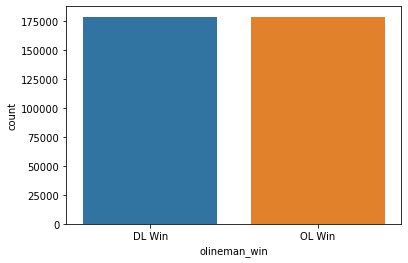

In [13]:
df_class_1_under = df_class_1.sample(count_class_0, replace=True)
df_under         = pd.concat([df_class_1_under, df_class_0], axis=0)
print('Random Under-Sampling:')
print(df_under.olineman_win.value_counts())
#plot
ax = sns.countplot(x=df_under['olineman_win']); 
ax.set_xticklabels(class_names)
plt.show()

In [14]:
df_under.head()

,dir_std,o_std,yardLine_std,Opp_Dist,closestOpp_Id,Team_Dist,closestTeam_Id,QB_Dist,closestQB_Id,FootDist,secondsIntoGame,secondsIntoPlay,down,yardsToGo,preSnapHomeScore,preSnapVisitorScore,pff_nflIdBlockedPlayer,defendersInBox,pff_playAction,penaltyCommitted,pff_positionLinedUp_LG,pff_positionLinedUp_LT,pff_positionLinedUp_RG,pff_positionLinedUp_RT,homeOrAway_home,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT,"personnelO_0 RB, 0 TE, 5 WR","personnelO_0 RB, 1 TE, 4 WR","personnelO_0 RB, 2 TE, 3 WR","personnelO_0 RB, 3 TE, 2 WR","personnelO_1 RB, 0 TE, 4 WR","personnelO_1 RB, 1 TE, 2 WR,1 LB","personnelO_1 RB, 1 TE, 3 WR","personnelO_1 RB, 2 TE, 2 WR","personnelO_1 RB, 3 TE, 1 WR","personnelO_1 RB, 4 TE, 0 WR","personnelO_2 QB, 1 RB, 0 TE, 3 WR","personnelO_2 QB, 1 RB, 1 TE, 2 WR","personnelO_2 QB, 1 RB, 2 TE, 1 WR","personnelO_2 QB, 1 RB, 3 TE, 0 WR","personnelO_2 QB, 2 RB, 0 TE, 2 WR","personnelO_2 QB, 2 RB, 1 TE, 1 WR","personnelO_2 QB, 6 OL, 1 RB, 1 TE, 1 WR","personnelO_2 RB, 0 TE, 3 WR","personnelO_2 RB, 1 TE, 2 WR",...,"personnelO_7 OL, 1 RB, 0 TE, 2 WR","personnelD_0 DL, 3 LB, 8 DB","personnelD_0 DL, 5 LB, 6 DB","personnelD_1 DL, 2 LB, 8 DB","personnelD_1 DL, 3 LB, 7 DB","personnelD_1 DL, 4 LB, 6 DB","personnelD_1 DL, 5 LB, 5 DB","personnelD_2 DL, 2 LB, 7 DB","personnelD_2 DL, 3 LB, 6 DB","personnelD_2 DL, 4 LB, 5 DB","personnelD_2 DL, 5 LB, 4 DB","personnelD_3 DL, 1 LB, 7 DB","personnelD_3 DL, 2 LB, 6 DB","personnelD_3 DL, 3 LB, 5 DB","personnelD_3 DL, 4 LB, 4 DB","personnelD_3 DL, 5 LB, 3 DB","personnelD_4 DL, 1 LB, 6 DB","personnelD_4 DL, 2 LB, 5 DB","personnelD_4 DL, 3 LB, 4 DB","personnelD_4 DL, 4 LB, 3 DB","personnelD_4 DL, 5 LB, 2 DB","personnelD_4 DL, 6 LB, 1 DB","personnelD_5 DL, 1 LB, 5 DB","personnelD_5 DL, 2 LB, 4 DB","personnelD_5 DL, 3 LB, 3 DB","personnelD_5 DL, 5 LB, 1 DB","personnelD_6 DL, 2 LB, 3 DB","personnelD_6 DL, 3 LB, 2 DB","personnelD_6 DL, 4 LB, 1 DB",dropBackType_DESIGNED_ROLLOUT_LEFT,dropBackType_DESIGNED_ROLLOUT_RIGHT,dropBackType_DESIGNED_RUN,dropBackType_SCRAMBLE,dropBackType_SCRAMBLE_ROLLOUT_LEFT,dropBackType_SCRAMBLE_ROLLOUT_RIGHT,dropBackType_TRADITIONAL,pff_passCoverage_2-Man,pff_passCoverage_Bracket,pff_passCoverage_Cover-0,pff_passCoverage_Cover-1,pff_passCoverage_Cover-2,pff_passCoverage_Cover-3,pff_passCoverage_Cover-6,pff_passCoverage_Goal Line,pff_passCoverage_Prevent,pff_passCoverage_Quarters,pff_passCoverage_Red Zone,pff_passCoverageType_Man,pff_passCoverageType_Zone,olineman_win
12191,2.734756,2.384992,27,1.130044,53587.0,8.573756,53443.0,11.187752,53431.0,11.649318,3037,6.5,1,10,16,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1
319744,1.268505,0.230383,29,2.038357,38556.0,2.276071,39965.0,5.466187,47784.0,4.569683,2412,0.7,2,5,7,10,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
1732453,2.609267,0.694292,60,0.725603,47795.0,3.354072,43484.0,4.128256,42831.0,4.033423,1837,1.5,2,8,7,7,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1
1509856,2.075546,0.172788,73,2.950203,44880.0,1.782134,52589.0,4.519347,41258.0,3.418435,2567,3.6,2,10,7,3,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1
1109770,3.224845,5.516462,54,1.627544,41786.0,1.741867,46106.0,4.352712,43291.0,2.880017,3731,0.4,3,2,10,21,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1


In [15]:
X = df_under.drop(['olineman_win'], axis = 1)
y = df_under.olineman_win

Undersample because very large dataset

### 2.2 Random Forest

In [16]:
#train test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [17]:
# param_grid = {
#     "n_estimators": [90, 120],
#     "criterion":("gini", "entropy"), 
#     "max_depth":([15,20])
# }
# #Random forest classifier
# clf = RandomForestClassifier(bootstrap=False,random_state=42)
# tree_cv = GridSearchCV(estimator=clf, param_grid = param_grid, scoring="accuracy", n_jobs=-1, verbose=1, cv=10)
# tree_cv.fit(X_tr, y_tr)
# best_params = tree_cv.best_params_
# print(f"Best paramters: {best_params})")
# #
# clf = RandomForestClassifier(**best_params,random_state=42)
# clf.fit(X_tr, y_tr)
# y_pred = clf.predict(X_te)
# #
# acc = accuracy_score(y_te, y_pred)
# cm = confusion_matrix(y_te, y_pred)
# fig, ax = plt.subplots(figsize=(5, 3),dpi= 100)
# ax =sns.heatmap(cm/np.sum(cm),annot = True,cmap = "inferno",xticklabels=class_names,yticklabels=class_names)
# plt.yticks(rotation=0) 
# plt.title('accuracy = %3.3f'%acc)
# ax.axis('equal')
# plt.xlabel('true label')
# plt.ylabel('predicted label')
# plt.show()

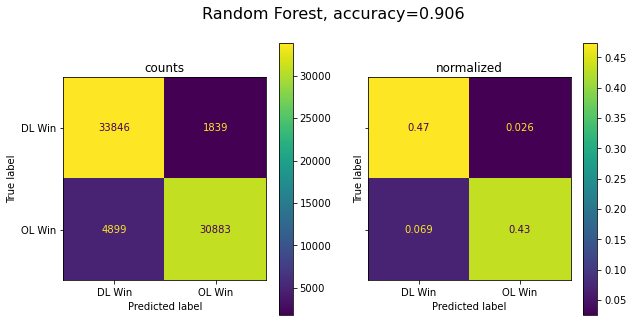

In [18]:
#Random forest classifier
clf = RandomForestClassifier(n_estimators=90,random_state=42,max_depth=20)
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)
acc = accuracy_score(y_te, y_pred)
cm = confusion_matrix(y_te, y_pred)
#plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names ) 
cmd.plot(ax=axes[0])
axes[0].set_title('counts')
cmd = ConfusionMatrixDisplay(cm/np.sum(cm[:]),display_labels=class_names) 
cmd.plot(ax=axes[1])
axes[1].set_title('normalized')
fig.suptitle('Random Forest, accuracy=%2.3f'%(acc), fontsize=16);
# fig, ax = plt.subplots(figsize=(5, 3),dpi= 100)
# ax =sns.heatmap(cm,annot = True,cmap = "inferno",xticklabels=class_names,yticklabels=class_names)
# plt.yticks(rotation=0) 
# plt.title('accuracy = %2.2f'%acc)
# ax.axis('equal')
# plt.xlabel('true label')
# plt.ylabel('predicted label')
# plt.show()

In [19]:
print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     35685
           1       0.94      0.86      0.90     35782

    accuracy                           0.91     71467
   macro avg       0.91      0.91      0.91     71467
weighted avg       0.91      0.91      0.91     71467



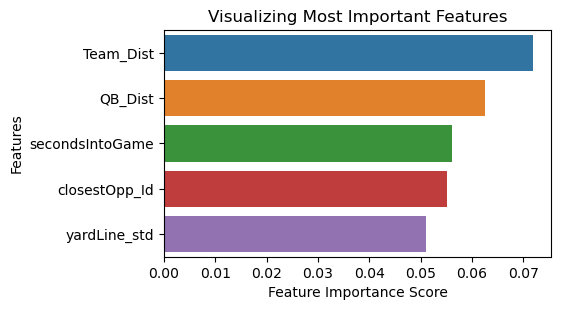

In [20]:
#view feature importance
features = X.columns.tolist()
feature_imp = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False).head(5)
# Creating a bar plot
fig, ax = plt.subplots(figsize=(5, 3),dpi= 100)  #original shape was 8.1, 10
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Most Important Features")
plt.show()

### Apply model to full dataset

In [21]:
X = df2.drop([ 'olineman_win'], axis = 1)
y = df2.olineman_win

In [22]:
#train test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2, random_state = 42)

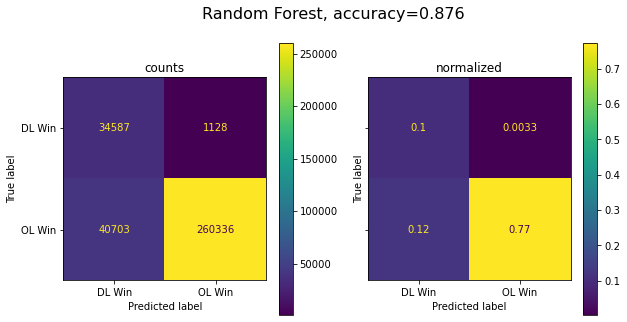

In [41]:
y_pred = clf.predict(X_te)
acc = accuracy_score(y_te, y_pred)
cm = confusion_matrix(y_te, y_pred)
#plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names ) 
cmd.plot(ax=axes[0])
axes[0].set_title('counts')
cmd = ConfusionMatrixDisplay(cm/np.sum(cm[:]),display_labels=class_names) 
cmd.plot(ax=axes[1])
axes[1].set_title('normalized')
fig.suptitle('Random Forest, accuracy=%2.3f'%(acc), fontsize=16);

In [42]:
print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.97      0.62     35715
           1       1.00      0.86      0.93    301039

    accuracy                           0.88    336754
   macro avg       0.73      0.92      0.77    336754
weighted avg       0.94      0.88      0.89    336754



### Make DF of Predictions and Rank Olinemen

In [43]:
# Make WR win predictions a DF
pred_OLwin = y_pred
pred_OLwin = pd.DataFrame(pred_OLwin, columns = ['pred_OLwin'])
df3 = pred_OLwin.join(df['displayName'])
df3 = df3.join(X)
df3.head()

,pred_OLwin,displayName,dir_std,o_std,yardLine_std,Opp_Dist,closestOpp_Id,Team_Dist,closestTeam_Id,QB_Dist,closestQB_Id,FootDist,secondsIntoGame,secondsIntoPlay,down,yardsToGo,preSnapHomeScore,preSnapVisitorScore,pff_nflIdBlockedPlayer,defendersInBox,pff_playAction,penaltyCommitted,pff_positionLinedUp_LG,pff_positionLinedUp_LT,pff_positionLinedUp_RG,pff_positionLinedUp_RT,homeOrAway_home,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT,"personnelO_0 RB, 0 TE, 5 WR","personnelO_0 RB, 1 TE, 4 WR","personnelO_0 RB, 2 TE, 3 WR","personnelO_0 RB, 3 TE, 2 WR","personnelO_1 RB, 0 TE, 4 WR","personnelO_1 RB, 1 TE, 2 WR,1 LB","personnelO_1 RB, 1 TE, 3 WR","personnelO_1 RB, 2 TE, 2 WR","personnelO_1 RB, 3 TE, 1 WR","personnelO_1 RB, 4 TE, 0 WR","personnelO_2 QB, 1 RB, 0 TE, 3 WR","personnelO_2 QB, 1 RB, 1 TE, 2 WR","personnelO_2 QB, 1 RB, 2 TE, 1 WR","personnelO_2 QB, 1 RB, 3 TE, 0 WR","personnelO_2 QB, 2 RB, 0 TE, 2 WR","personnelO_2 QB, 2 RB, 1 TE, 1 WR","personnelO_2 QB, 6 OL, 1 RB, 1 TE, 1 WR",...,"personnelO_6 OL, 2 RB, 1 TE, 1 WR","personnelO_7 OL, 1 RB, 0 TE, 2 WR","personnelD_0 DL, 3 LB, 8 DB","personnelD_0 DL, 5 LB, 6 DB","personnelD_1 DL, 2 LB, 8 DB","personnelD_1 DL, 3 LB, 7 DB","personnelD_1 DL, 4 LB, 6 DB","personnelD_1 DL, 5 LB, 5 DB","personnelD_2 DL, 2 LB, 7 DB","personnelD_2 DL, 3 LB, 6 DB","personnelD_2 DL, 4 LB, 5 DB","personnelD_2 DL, 5 LB, 4 DB","personnelD_3 DL, 1 LB, 7 DB","personnelD_3 DL, 2 LB, 6 DB","personnelD_3 DL, 3 LB, 5 DB","personnelD_3 DL, 4 LB, 4 DB","personnelD_3 DL, 5 LB, 3 DB","personnelD_4 DL, 1 LB, 6 DB","personnelD_4 DL, 2 LB, 5 DB","personnelD_4 DL, 3 LB, 4 DB","personnelD_4 DL, 4 LB, 3 DB","personnelD_4 DL, 5 LB, 2 DB","personnelD_4 DL, 6 LB, 1 DB","personnelD_5 DL, 1 LB, 5 DB","personnelD_5 DL, 2 LB, 4 DB","personnelD_5 DL, 3 LB, 3 DB","personnelD_5 DL, 5 LB, 1 DB","personnelD_6 DL, 2 LB, 3 DB","personnelD_6 DL, 3 LB, 2 DB","personnelD_6 DL, 4 LB, 1 DB",dropBackType_DESIGNED_ROLLOUT_LEFT,dropBackType_DESIGNED_ROLLOUT_RIGHT,dropBackType_DESIGNED_RUN,dropBackType_SCRAMBLE,dropBackType_SCRAMBLE_ROLLOUT_LEFT,dropBackType_SCRAMBLE_ROLLOUT_RIGHT,dropBackType_TRADITIONAL,pff_passCoverage_2-Man,pff_passCoverage_Bracket,pff_passCoverage_Cover-0,pff_passCoverage_Cover-1,pff_passCoverage_Cover-2,pff_passCoverage_Cover-3,pff_passCoverage_Cover-6,pff_passCoverage_Goal Line,pff_passCoverage_Prevent,pff_passCoverage_Quarters,pff_passCoverage_Red Zone,pff_passCoverageType_Man,pff_passCoverageType_Zone
0,0,Donovan Smith,5.545260,1.012640,33.0,2.151279,53504.0,1.293406,42404.0,4.627883,25511.0,3.162183,87.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,Donovan Smith,5.431814,1.012640,33.0,2.161227,53504.0,1.287051,42404.0,4.605779,25511.0,3.049098,87.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,Donovan Smith,3.869395,0.991871,33.0,2.172211,53504.0,1.296534,42404.0,4.591841,25511.0,3.067507,87.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,Donovan Smith,3.013485,0.991871,33.0,2.211990,53504.0,1.3063

In [44]:
df3 = df3[['pred_OLwin', 'displayName', 'pff_positionLinedUp_LT', 'pff_positionLinedUp_LG', 'pff_positionLinedUp_RG', 'pff_positionLinedUp_RT']]

In [45]:
df3.head()

,pred_OLwin,displayName,pff_positionLinedUp_LT,pff_positionLinedUp_LG,pff_positionLinedUp_RG,pff_positionLinedUp_RT
0,0,Donovan Smith,1.0,0.0,0.0,0.0
1,1,Donovan Smith,1.0,0.0,0.0,0.0
2,0,Donovan Smith,1.0,0.0,0.0,0.0
3,0,Donovan Smith,1.0,0.0,0.0,0.0
4,0,Donovan Smith,1.0,0.0,0.0,0.0


In [46]:
df3 = df3.join(df.playId)

In [49]:
# top linemen
average_win = df3.groupby(['displayName', 'playId']).mean('pred_OLwin').reset_index()
num_wins = df3.groupby('displayName').sum('pred_OLwin').reset_index()
best_OL = num_wins.sort_values(by = 'pred_OLwin', ascending = False).reset_index(drop = True)
best_OL = best_OL.drop('playId', axis = 1)

In [50]:
best_OL.head()

,displayName,pred_OLwin,pff_positionLinedUp_LT,pff_positionLinedUp_LG,pff_positionLinedUp_RG,pff_positionLinedUp_RT
0,Penei Sewell,9638,12297.0,0.0,0.0,0.0
1,Orlando Brown,8932,11653.0,0.0,0.0,0.0
2,Charles Leno,8373,10752.0,0.0,0.0,0.0
3,Jake Matthews,8213,10543.0,0.0,0.0,0.0
4,Dion Dawkins,8090,10407.0,0.0,0.0,0.0


In [51]:
best_OL.to_csv('best_OL.csv', index = False)